## a2wv - audio2word-vector

We try implementing the audio 2 word vector approach proposed [here](https://infoscience.epfl.ch/record/268742). We use the Google Speech command dataset.

![A2WV](../Images/a2wv.png)

In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import hashlib
import random
from tqdm import tqdm
from python_speech_features import mfcc
import scipy.io.wavfile as wav

In [2]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

    Returns:
    String, one of 'training', 'validation', or 'testing'.
    """
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode('utf-8')
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result

**Import keywords**

The unseen keywords set is used at the very end to verify how our embeddings extraction approach works for data that it has never seen

In [3]:
keywords = ['yes', 'down', 'left', 'on', 'stop', 'three', 'no', 'up', 'right']
unseen_keywords = ['no', 'up', 'right']
nb_labels = len(keywords) - len(unseen_keywords)

Get keyword filename of audio samples

In [4]:
path = os.path.abspath("../Datasets/google_dataset/")

In [5]:
filenames = []
unseen_filenames = []
for kw in keywords:
    current_path = os.path.join(path, kw) 
    for _, _, files in os.walk(current_path):
        #sampled_files = np.random.choice(files, size=10, replace=False)
        for file in files:
            if kw in unseen_keywords:
                unseen_filenames.append(os.path.join(current_path, file))
            else:
                filenames.append(os.path.join(current_path, file))

**Define MFCC features extraction function**

In [6]:
def compute_mfcc(signal, num_features=40):
    """Extract the mfcc features
    Args:
    signal: time domain signal.
    num_features: number of cepstrum to return. Default to 40.

    Returns:
    Numpy array of shape (1, num_features) containing the MFCC features for signal
    """
    features = mfcc(signal, samplerate=16000, winlen=0.030, winstep=0.01, numcep=num_features, 
                         lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=num_features)
    features = np.mean(features, axis=0).reshape(1,-1)
    return features

In [7]:
fs, sig = wav.read(random.choice(filenames))
feats = compute_mfcc(sig)

In [8]:
feats.shape

(1, 40)

**Prepare data for training, validating and testing**

In [9]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import GRU, Input, concatenate, Flatten, Dense, CuDNNGRU
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


We first define some helper functions to prepare our data

In [10]:
def generate_sets(filenames, validation_percentage=10, testing_percentage=10):
    """Generate training, validation and testing sets
    Args:
    filenames: File paths data samples.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

    Returns:
    Lists training, validation and testing with elements (features, label)
    """
    
    non_keywords_label = len(keywords)

    training, validation, testing = [], [], []
    #min_nb_frames = 98
    for filename in tqdm(filenames):
        _, signal = wav.read(filename)
        feats = compute_mfcc(signal)
        
        #if feats.shape[0] < min_nb_frames:
            #continue
        kw = filename.split('/')[-2]
        if kw in keywords:
            label = keywords.index(kw)
        else:
            label = non_keywords_label
            
        grp = which_set(filename, validation_percentage, testing_percentage)
        
        if grp is 'training':
            training.append((feats, label))
        elif grp is 'validation':
            validation.append((feats, label))
        else:
            testing.append((feats, label))
    return training, validation, testing

def get_X_y(grp, num_features=40):
    """Extract data in correct format given input from function `generate sets`
    Args:
    grp: list returned by function `generate sets` with elements (features, label).
    num_features: number of cepstrum to return. Default to 40.

    Returns:
    Two numpy array of shape (number_of_samples, 1, num_features) & (number_of_samples, 1) representing respectively the data samples and their labels
    """
    X, y = zip(*grp)
    return np.array(X).reshape(-1, 1, num_features), np.array(y).reshape(-1,1)

**Triplet loss**

We use the **triplet loss** with the batch hard technique to update the weights of our model. <br>
The loss is defined as follows :

![triplet_loss](../Images/triplet_loss_function.png)

![figure_triplet](../Images/figure_triplet.png)

In [11]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask

def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

def batch_hard_triplet_loss(y_true, y_pred):#(labels, embeddings, margin=1, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        y_true: ground truth labels with embeddings
        y_pred: predicted labels with embeddings
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    #  Margin for triplet loss
    margin = 1
    
    # Boolean. If true, output is the pairwise squared euclidean distance matrix. If false, output is the pairwise euclidean distance matrix.
    squared=True
    
    # labels of the batch, of size (batch_size,)
    labels = y_pred[:, :1]
    labels = tf.cast(labels, dtype='int32')
    
    # tensor of shape (batch_size, embed_dim)
    embeddings = y_pred[:, 1:]
    
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss


We create our own batch generator as the *batch-hard technique* is greatly sensitive to the presence of outliers and mislabeled samples

In [12]:
def batch_generator(X, y, nb_labels, P=6, K=200, embedding_size=64):
    """Generates a batch of P*K embeddings (K samples from P classes). 
    Args:
        X: data samples, of size (number_of_samples, 1, num_features)
        y: labels (number_of_samples, 1)
        P: number of classes to select samples from
        K: number samples to select from class
        embedding_size : int
        
    Returns:
        Custom generator used for training
    """
    while True:

        selected_classes = np.random.choice(a=range(nb_labels), size=min(P,nb_labels), replace=False)        
        X_batch = np.array([]).reshape(0, 1, X.shape[-1])
        y_batch = np.array([]).reshape(0, 1)
        
        for label in selected_classes:
            X_label = X[y[:,0] == label]
            indices_samples = np.random.choice(a=range(len(X_label)), size=K)
            selected_samples = X_label[indices_samples,:]
            X_batch = np.concatenate((X_batch, selected_samples), axis=0)
            y_batch = np.concatenate((y_batch, label * np.ones((len(indices_samples), 1))), axis=0)
                
        # Return a tuple of (input,output) to feed the network
        batch_x = [X_batch, y_batch]
        batch_y = np.zeros((P*K, embedding_size + 1))
        
        yield( batch_x, batch_y )
        

**Define model architecture**

In [13]:
def a2wv_model():
    
    input_feats = Input(shape=(1,40))
    x = GRU(units=64, activation='tanh', return_sequences=True)(input_feats)
    x = GRU(units=64, activation='tanh', return_sequences=True, dropout=0.3)(x)
    x = Flatten()(x)
    #x = Dense(64, activation='tanh')(x)
    base_network = Model(inputs=input_feats, outputs=x)
    return base_network

**Generate datasets**

In [14]:
training, validation, testing = generate_sets(filenames, validation_percentage=10, testing_percentage=10)


100%|██████████| 14192/14192 [00:25<00:00, 555.24it/s]


In [15]:
#from random import sample 

#def sample_data(data, nb_labels, nb_samples=25):
#    sampled_data = []
#    for label in range(nb_labels):
#        data_label = list(filter(lambda x : x[1] == label, data))
#        sampled_data.extend(sample(data_label, k=min(nb_samples, len(data_label))))
#    return sampled_data

In [16]:
#training, validation, testing = sample_data(training, nb_labels, nb_samples=20), sample_data(validation, nb_labels, nb_samples=5), sample_data(testing, nb_labels, nb_samples=5)

In [17]:
X_train, y_train = get_X_y(training)
X_validation, y_validation = get_X_y(validation)
X_test, y_test = get_X_y(testing)


**Train model**

In [ ]:
input_feats = Input(shape=(1, 40), name='input_feats')
input_labels = Input(shape=(1,), name='input_label') 

a2wv = a2wv_model() # output of network -> embeddings
embeddings = a2wv([input_feats])
labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

model = Model(inputs=[input_feats, input_labels],
                outputs=labels_plus_embeddings)

opt = Adam(lr=0.001) 
model.compile(loss=batch_hard_triplet_loss, 
              optimizer=opt)

embedding_size = 64
dummy_gt_train = np.zeros((len(X_train), embedding_size + 1))
dummy_gt_val = np.zeros((len(X_validation), embedding_size + 1))

gen = batch_generator(X_train, y_train, nb_labels=nb_labels)
model.fit_generator(gen, steps_per_epoch=100, epochs=1, verbose=1, validation_data=([X_validation, y_validation], dummy_gt_val))

In [32]:
model.fit_generator(gen, steps_per_epoch=100, epochs=1, verbose=1, validation_data=([X_validation, y_validation], dummy_gt_val))

Epoch 1/1
100/100 [==============================] - 1041s 10s/step - loss: 1.3842 - val_loss: 1.1089


**Compute embeddings**

Create empty network and use trained model to obtain embeddings for test set and `super_embeddings` which are the representative embeddings for each keyword.

In [19]:
testing_embeddings = a2wv_model() 
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights

In [20]:
embeddings_train = testing_embeddings.predict(X_train)


In [21]:
embeddings_train = np.concatenate((y_train, embeddings_train), axis=1)


In [22]:
embeddings_train.shape


(11131, 65)

**Classification**

In [23]:
#embeddings_train = model.predict(x=[X_train, y_train])
super_embeddings = []
for label in range(nb_labels):
    super_embeddings.append(np.mean(embeddings_train[embeddings_train[:,0]==label], axis=0 ) )
super_embeddings = np.array(super_embeddings)


In [24]:
super_embeddings.shape


(6, 65)

In [25]:
embeddings_train[0,:].shape


(65,)

Compute distances between *super embedding* and new data point

In [26]:
def predict_label(new_embedding):
    repeated_emb = np.repeat(new_embedding[1:].reshape(1,-1), super_embeddings.shape[0], axis=0) 
    distances = np.linalg.norm(super_embeddings[:,1:] - repeated_emb, axis=1)
    index_min = np.argmin(distances)
    pred_label = super_embeddings[index_min, 0]
    return pred_label


In [27]:
def predict_labels(embeddings):
    preds = list(map(lambda x: predict_label(x), embeddings))
    return preds


In [28]:
from sklearn.metrics import accuracy_score


In [29]:
#embeddings_test_seen = model.predict(x=[X_test, y_test])
embeddings_test_seen = testing_embeddings.predict(X_test)
embeddings_test_seen = np.concatenate((y_test, embeddings_test_seen), axis=1)


In [30]:
preds = predict_labels(embeddings_test_seen)
accuracy_score(embeddings_test_seen[:,0], preds)


0.3673602080624187

**t-sne visualization**

In [32]:
_, _, unseen_data = generate_sets(unseen_filenames, validation_percentage=10, testing_percentage=10)
X_unseen, y_unseen = get_X_y(unseen_data)


100%|██████████| 7117/7117 [00:11<00:00, 624.87it/s]


In [33]:
#embeddings_unseen = model.predict(x=[X_unseen, y_unseen])
embeddings_unseen = testing_embeddings.predict(X_unseen)
embeddings_unseen = np.concatenate((y_unseen, embeddings_unseen), axis=1)


In [34]:
embeddings_unseen.shape

(783, 65)

In [35]:
embeddings_test_seen.shape

(1538, 65)

In [36]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
embeddings = np.concatenate((embeddings_unseen, embeddings_test_seen), axis=0)

In [38]:
embeddings_2 = TSNE(n_components=2, verbose=1, perplexity=70).fit_transform(embeddings[:,1:])

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 2321 samples in 0.006s...
[t-SNE] Computed neighbors for 2321 samples in 0.610s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2321
[t-SNE] Computed conditional probabilities for sample 2000 / 2321
[t-SNE] Computed conditional probabilities for sample 2321 / 2321
[t-SNE] Mean sigma: 0.058448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.160591
[t-SNE] KL divergence after 1000 iterations: 1.556630


In [39]:
df_embeddings = pd.DataFrame(columns=['x', 'y'])
df_embeddings['x'] = embeddings_2[:,0]
df_embeddings['y'] = embeddings_2[:,1]
df_embeddings['keywords'] = list(map(lambda x : keywords[int(x)]  + '(unseen)' if keywords[int(x)] in unseen_keywords else keywords[int(x)], embeddings[:,0]))


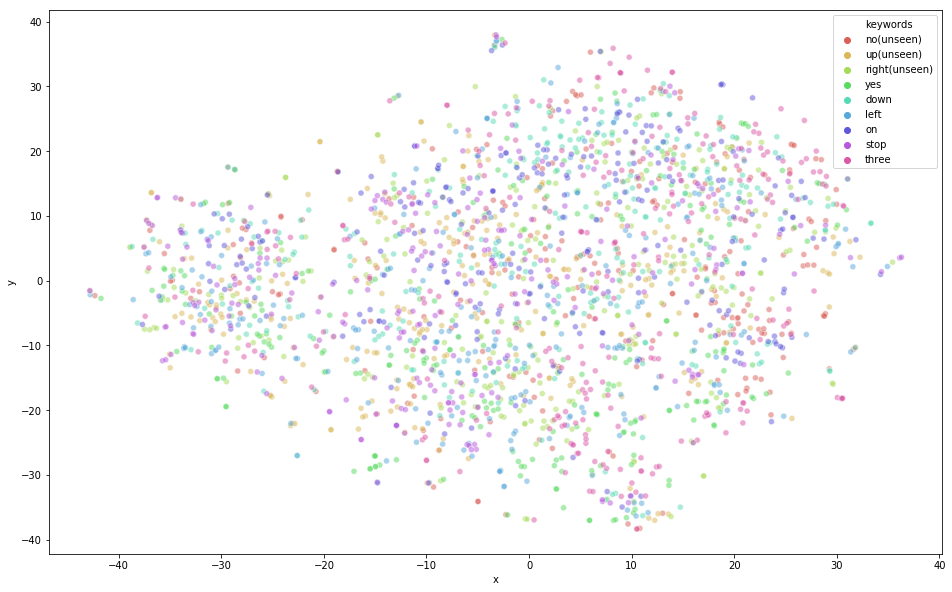

In [40]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="keywords",
    palette=sns.color_palette("hls",len(keywords)),
    data=df_embeddings,
    legend="full",
    alpha=0.5
)
